In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from keras.models import Sequential
import matplotlib.patches as mpatches
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from google.colab import files

import os


In [2]:
uploaded=files.upload()
temperature=pd.read_csv("Temperature.csv",parse_dates= {"date" : ["year","month","day"]},
                keep_date_col=True)
#convert the temperature from object to int 64/float
temperature.max_temp = pd.to_numeric(temperature.max_temp, errors='coerce')
temperature.min_temp = pd.to_numeric(temperature.min_temp, errors='coerce')
temperature.mean_temp = pd.to_numeric(temperature.mean_temp, errors='coerce')

#remove the row which has NaN value
temperature=temperature.dropna()
temperature.head(10)

temp_max_data = temperature[["date","max_temp"]]
temp_min_data = temperature[["date","min_temp"]]
temp_mean_data = temperature[["date","mean_temp"]]

temp_max_data["date"] = pd.to_datetime(temp_max_data['date'], infer_datetime_format=True)
temp_max_data = temp_max_data.set_index(["date"])
temp_min_data["date"] = pd.to_datetime(temp_min_data['date'], infer_datetime_format=True)
temp_min_data = temp_min_data.set_index(["date"])
temp_mean_data["date"] = pd.to_datetime(temp_mean_data['date'], infer_datetime_format=True)
temp_mean_data = temp_mean_data.set_index(["date"])


Saving Temperature.csv to Temperature.csv


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [3]:
temp_max_data  =temp_max_data.resample('D').mean()

In [4]:
temp_min_data  =temp_min_data.resample('D').mean()

In [5]:
temp_mean_data  =temp_mean_data.resample('D').mean()

In [6]:
temp_max_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5752 entries, 2007-01-01 to 2022-09-30
Freq: D
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   max_temp  5736 non-null   float64
dtypes: float64(1)
memory usage: 89.9 KB


In [7]:
temp_min_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5752 entries, 2007-01-01 to 2022-09-30
Freq: D
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   min_temp  5736 non-null   float64
dtypes: float64(1)
memory usage: 89.9 KB


In [8]:
temp_mean_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5752 entries, 2007-01-01 to 2022-09-30
Freq: D
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   mean_temp  5736 non-null   float64
dtypes: float64(1)
memory usage: 89.9 KB


In [9]:
from scipy.interpolate import interp1d

In [10]:
temp_max_data['max_temp'] = temp_max_data['max_temp'].interpolate()# we will fill the null row

In [11]:
temp_min_data['min_temp'] = temp_min_data['min_temp'].interpolate()# we will fill the null row

In [12]:
temp_mean_data['mean_temp'] = temp_mean_data['mean_temp'].interpolate()# we will fill the null row

In [13]:
temp_max_df = temp_max_data.copy()
temp_min_df = temp_min_data.copy()
temp_mean_df = temp_mean_data.copy()

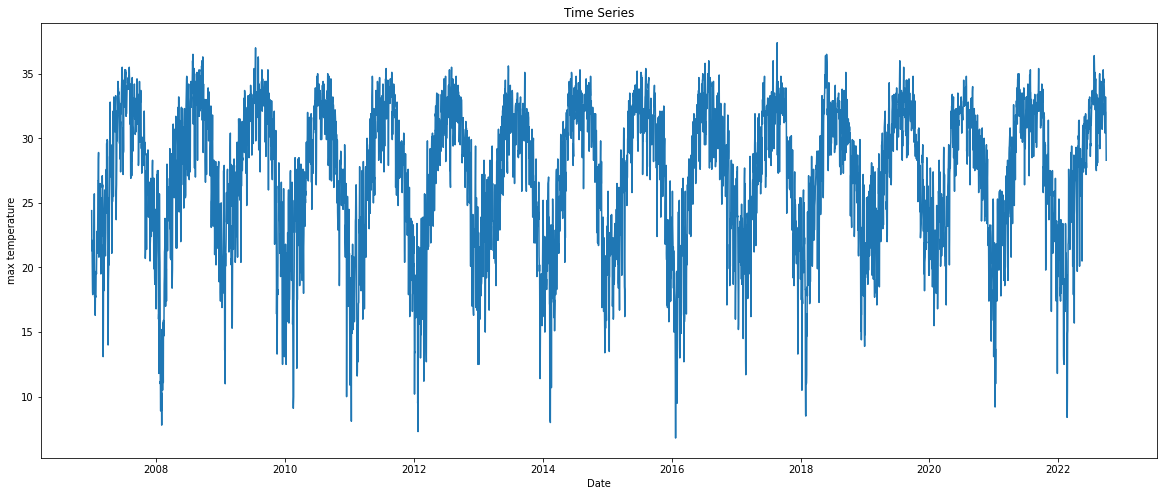

In [14]:
plt.figure(figsize=(20,8))
plt.plot(temp_max_data)
plt.title('Time Series')
plt.xlabel('Date')
plt.ylabel('max temperature')
plt.show()

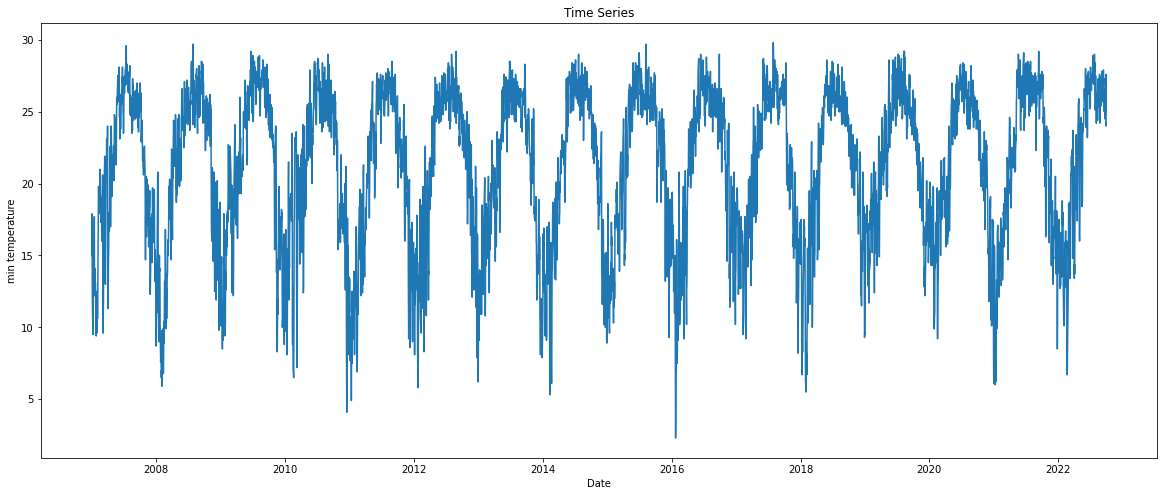

In [15]:
plt.figure(figsize=(20,8))
plt.plot(temp_min_data)
plt.title('Time Series')
plt.xlabel('Date')
plt.ylabel('min temperature')
plt.show()

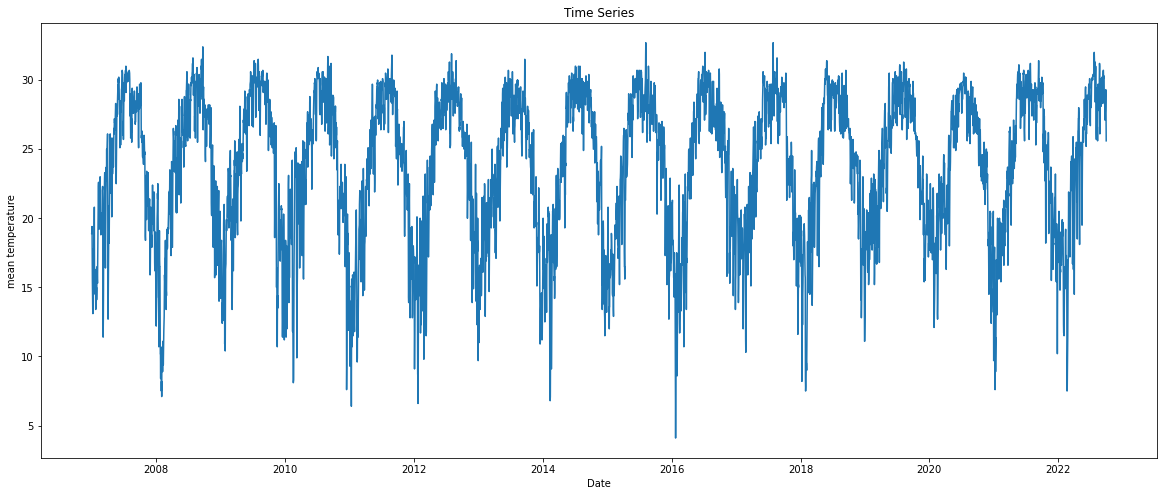

In [16]:
plt.figure(figsize=(20,8))
plt.plot(temp_mean_data)
plt.title('Time Series')
plt.xlabel('Date')
plt.ylabel('mean temperature')
plt.show()

In [17]:
temp_max_data = temp_max_data.values
temp_max_data = temp_max_data.astype('float32')

In [18]:
scaler= MinMaxScaler(feature_range=(-1,1))
max_sc = scaler.fit_transform(temp_max_data)


In [19]:
max_sc

array([[ 0.15032673],
       [-0.0522877 ],
       [ 0.        ],
       ...,
       [ 0.6470587 ],
       [ 0.496732  ],
       [ 0.4052286 ]], dtype=float32)

In [20]:
timestep = 30

X= []
Y=[]


for i in range(len(max_sc)- (timestep)):
    X.append(max_sc[i:i+timestep])
    Y.append(max_sc[i+timestep])


X=np.asanyarray(X)
Y=np.asanyarray(Y)


k = 5602
Xtrain = X[:k,:,:]
Xtest = X[k:,:,:]    
Ytrain = Y[:k]    
Ytest= Y[k:]   

In [21]:
print(Xtrain.shape)
print(Xtest.shape)

(5602, 30, 1)
(120, 30, 1)


In [22]:
model = Sequential()

model.add(LSTM(32,activation = 'relu', input_shape= (30,1), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(LSTM(32, activation='sigmoid', return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 32)            4352      
                                                                 
 lstm_1 (LSTM)               (None, 30, 32)            8320      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 21,025
Trainable params: 21,025
Non-trainable params: 0
_________________________________________________________________


In [24]:
history = model.fit(Xtrain,Ytrain,epochs=50, verbose=1)

Epoch 1/50
176/176 [==============================] - 10s 33ms/step - loss: 0.0685
Epoch 2/50
176/176 [==============================] - 6s 33ms/step - loss: 0.0374
Epoch 3/50
176/176 [==============================] - 6s 33ms/step - loss: 0.0281
Epoch 4/50
176/176 [==============================] - 8s 43ms/step - loss: 0.0235
Epoch 5/50
176/176 [==============================] - 6s 33ms/step - loss: 0.0227
Epoch 6/50
176/176 [==============================] - 6s 33ms/step - loss: 0.0221
Epoch 7/50
176/176 [==============================] - 6s 33ms/step - loss: 0.0228
Epoch 8/50
176/176 [==============================] - 6s 33ms/step - loss: 0.0222
Epoch 9/50
176/176 [==============================] - 6s 33ms/step - loss: 0.0223
Epoch 10/50
176/176 [==============================] - 6s 33ms/step - loss: 0.0217
Epoch 11/50
176/176 [==============================] - 6s 33ms/step - loss: 0.0220
Epoch 12/50
176/176 [==============================] - 6s 33ms/step - loss: 0.0218
Epoch 13/50


Text(0.5, 1.0, 'Model Accuracy')

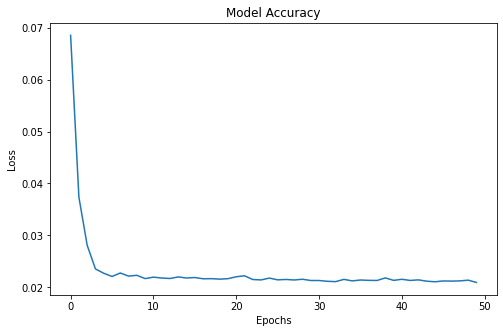

In [25]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Accuracy")

In [26]:
preds= model.predict(Xtest)
preds = scaler.inverse_transform(preds)


Ytest=np.asanyarray(Ytest)  
Ytest=Ytest.reshape(-1,1) 
Ytest = scaler.inverse_transform(Ytest)


Ytrain=np.asanyarray(Ytrain)  
Ytrain=Ytrain.reshape(-1,1) 
Ytrain = scaler.inverse_transform(Ytrain)

mean_squared_error(Ytest,preds)

4/4 [==============================] - 0s 9ms/step


1.8981812

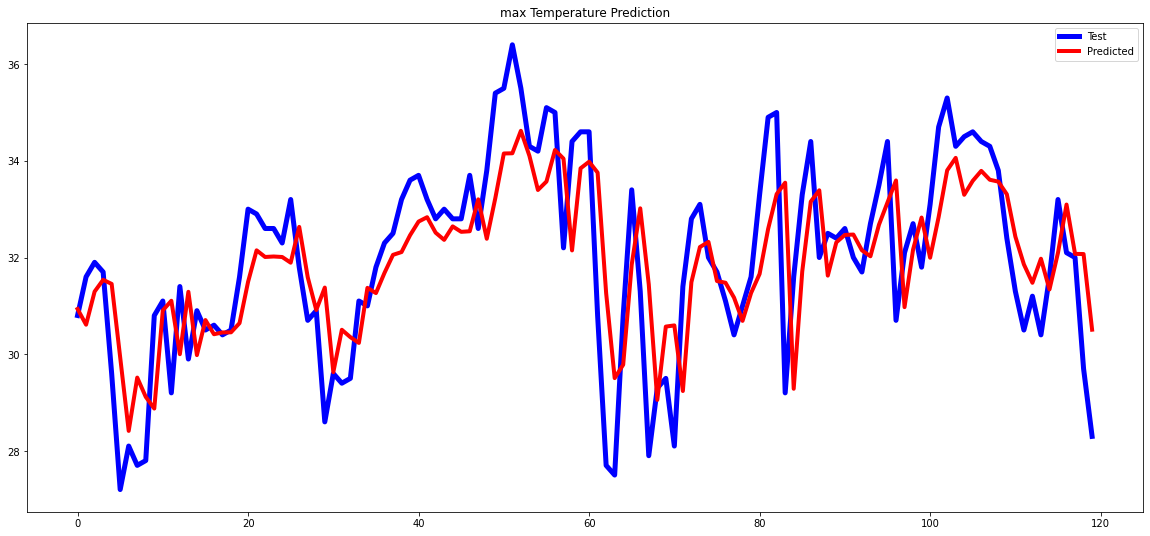

In [27]:
plt.figure(figsize=(20,9))
plt.plot(Ytest , 'blue', linewidth=5)
plt.plot(preds,'r' , linewidth=4)
plt.legend(('Test','Predicted'))
plt.title("max Temperature Prediction")
plt.show()


In [28]:
test = pd.DataFrame(Ytest,columns=['Actual'])
pred = pd.DataFrame(preds,columns=['Predict'])

In [29]:
results = pd.concat([test,pred],axis=1)

In [30]:
results.head(9)

,Actual,Predict
0,30.799999,30.935129
1,31.600000,30.610472
2,31.900000,31.294792
3,31.700001,31.538101
4,29.600000,31.453793
5,27.200001,29.935375
6,28.100000,28.413523
7,27.700001,29.516472
8,27.799999,29.117252


In [31]:
def insert_end(Xin,new_input):
    #print ('Before: \n', Xin , new_input )
    for i in range(timestep-1):
        Xin[:,i,:] = Xin[:,i+1,:]
    Xin[:,timestep-1,:] = new_input
    #print ('After :\n', Xin)
    return Xin


In [32]:
temp_max_df

,max_temp
date,
2007-01-01,24.4
2007-01-02,21.3
2007-01-03,22.1
2007-01-04,20.8
2007-01-05,19.8
...,...
2022-09-26,33.2
2022-09-27,32.1
2022-09-28,32.0


In [33]:
# this section for unknown future
#we are getting next 30 steps
from datetime import timedelta
future=60
forcast = []
Xin = Xtest[-1:,:,:]
time=[]
for i in range(future):
    out = model.predict(Xin, batch_size=1)    
    forcast.append(out[0,0]) 
    print(forcast)
    Xin = insert_end(Xin,out[0,0]) 
    time.append(pd.to_datetime(temp_max_df.index[-1])+timedelta(days=i+1))

1/1 [==============================] - 0s 23ms/step
[0.54946953]
1/1 [==============================] - 0s 20ms/step
[0.54946953, 0.59924346]
1/1 [==============================] - 0s 23ms/step
[0.54946953, 0.59924346, 0.6358531]
1/1 [==============================] - 0s 18ms/step
[0.54946953, 0.59924346, 0.6358531, 0.64503366]
1/1 [==============================] - 0s 22ms/step
[0.54946953, 0.59924346, 0.6358531, 0.64503366, 0.64330846]
1/1 [==============================] - 0s 22ms/step
[0.54946953, 0.59924346, 0.6358531, 0.64503366, 0.64330846, 0.6402381]
1/1 [==============================] - 0s 22ms/step
[0.54946953, 0.59924346, 0.6358531, 0.64503366, 0.64330846, 0.6402381, 0.6383991]
1/1 [==============================] - 0s 22ms/step
[0.54946953, 0.59924346, 0.6358531, 0.64503366, 0.64330846, 0.6402381, 0.6383991, 0.63762146]
1/1 [==============================] - 0s 22ms/step
[0.54946953, 0.59924346, 0.6358531, 0.64503366, 0.64330846, 0.6402381, 0.6383991, 0.63762146, 0.6374237

In [34]:
forcasted_output=np.asanyarray(forcast)   
forcasted_output=forcasted_output.reshape(-1,1) 
forcasted_output = scaler.inverse_transform(forcasted_output) 

In [35]:
forcasted_output = pd.DataFrame(forcasted_output)
date = pd.DataFrame(time)
df_result = pd.concat([date,forcasted_output],axis=1)
df_result.columns = "Date","Forecasted"

In [36]:
df_result

,Date,Forecasted
0,2022-10-01,30.506884
1,2022-10-02,31.268425
2,2022-10-03,31.828552
3,2022-10-04,31.969015
4,2022-10-05,31.942619
5,2022-10-06,31.895643
6,2022-10-07,31.867508
7,2022-10-08,31.855610
8,2022-10-09,31.852585
9,2022-10-10,31.854172


In [37]:
temp_min_data = temp_min_data.values
temp_min_data = temp_min_data.astype('float32')

In [38]:
scaler= MinMaxScaler(feature_range=(-1,1))
min_sc = scaler.fit_transform(temp_min_data)
min_sc

array([[-0.07636368],
       [ 0.07636368],
       [ 0.13454545],
       ...,
       [ 0.84000003],
       [ 0.57818186],
       [ 0.5999999 ]], dtype=float32)

In [39]:
timestep = 30

X= []
Y=[]


for i in range(len(min_sc)- (timestep)):
    X.append(max_sc[i:i+timestep])
    Y.append(max_sc[i+timestep])


X=np.asanyarray(X)
Y=np.asanyarray(Y)


k = 5602
Xtrain = X[:k,:,:]
Xtest = X[k:,:,:]    
Ytrain = Y[:k]    
Ytest= Y[k:]   

In [40]:
print(Xtrain.shape)
print(Xtest.shape)

(5602, 30, 1)
(120, 30, 1)


In [41]:
model = Sequential()

model.add(LSTM(32,activation = 'relu', input_shape=30,1), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(LSTM(32, activation='sigmoid', return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

SyntaxError: ignored

In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 32)            4352      
                                                                 
 lstm_1 (LSTM)               (None, 30, 32)            8320      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 21,025
Trainable params: 21,025
Non-trainable params: 0
_________________________________________________________________


In [42]:
history = model.fit(Xtrain,Ytrain,epochs=50, verbose=1)

Epoch 1/50
176/176 [==============================] - 6s 34ms/step - loss: 0.0212
Epoch 2/50
176/176 [==============================] - 6s 33ms/step - loss: 0.0213
Epoch 3/50
176/176 [==============================] - 6s 33ms/step - loss: 0.0211
Epoch 4/50
176/176 [==============================] - 6s 34ms/step - loss: 0.0212
Epoch 5/50
176/176 [==============================] - 6s 34ms/step - loss: 0.0210
Epoch 6/50
176/176 [==============================] - 6s 34ms/step - loss: 0.0211
Epoch 7/50
176/176 [==============================] - 6s 34ms/step - loss: 0.0213
Epoch 8/50
176/176 [==============================] - 6s 34ms/step - loss: 0.0209
Epoch 9/50
176/176 [==============================] - 7s 39ms/step - loss: 0.0210
Epoch 10/50
176/176 [==============================] - 7s 38ms/step - loss: 0.0211
Epoch 11/50
176/176 [==============================] - 9s 49ms/step - loss: 0.0209
Epoch 12/50
176/176 [==============================] - 6s 34ms/step - loss: 0.0210
Epoch 13/50
1

Text(0.5, 1.0, 'Model Accuracy')

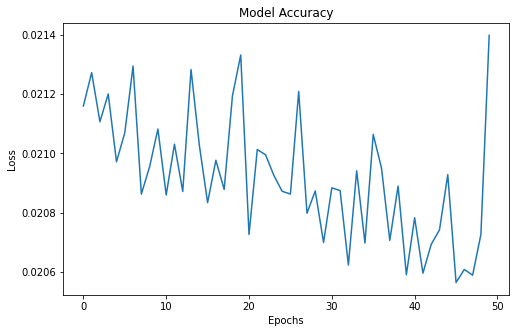

In [43]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Accuracy")

In [44]:
preds= model.predict(Xtest)
preds = scaler.inverse_transform(preds)


Ytest=np.asanyarray(Ytest)  
Ytest=Ytest.reshape(-1,1) 
Ytest = scaler.inverse_transform(Ytest)


Ytrain=np.asanyarray(Ytrain)  
Ytrain=Ytrain.reshape(-1,1) 
Ytrain = scaler.inverse_transform(Ytrain)

mean_squared_error(Ytest,preds)

4/4 [==============================] - 0s 10ms/step


1.5663923

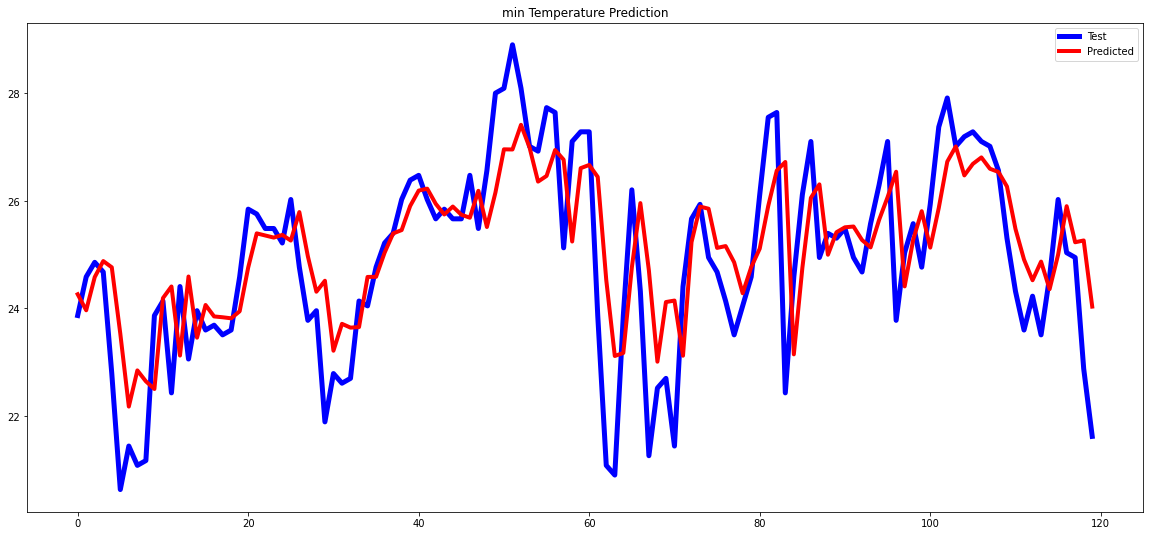

In [45]:
plt.figure(figsize=(20,9))
plt.plot(Ytest , 'blue', linewidth=5)
plt.plot(preds,'r' , linewidth=4)
plt.legend(('Test','Predicted'))
plt.title("min Temperature Prediction")
plt.show()


In [46]:
test = pd.DataFrame(Ytest,columns=['Actual'])
pred = pd.DataFrame(preds,columns=['Predict'])

In [47]:
results = pd.concat([test,pred],axis=1)

In [48]:
results.head(9)

,Actual,Predict
0,23.868626,24.263605
1,24.587580,23.965984
2,24.857187,24.582951
3,24.677450,24.880844
4,22.790195,24.764999
5,20.633333,23.530506
6,21.442156,22.176319
7,21.082680,22.848394
8,21.172548,22.645580


In [49]:
# this section for unknown future
#we are getting next 30 steps
from datetime import timedelta
future=90
forcast = []
Xin = Xtest[-1:,:,:]
time=[]
for i in range(future):
    out = model.predict(Xin, batch_size=1)    
    forcast.append(out[0,0]) 
    print(forcast)
    Xin = insert_end(Xin,out[0,0]) 
    time.append(pd.to_datetime(temp_max_df.index[-1])+timedelta(days=i+1))

1/1 [==============================] - 0s 20ms/step
[0.5806939]
1/1 [==============================] - 0s 18ms/step
[0.5806939, 0.63937116]
1/1 [==============================] - 0s 20ms/step
[0.5806939, 0.63937116, 0.67755806]
1/1 [==============================] - 0s 21ms/step
[0.5806939, 0.63937116, 0.67755806, 0.6939231]
1/1 [==============================] - 0s 20ms/step
[0.5806939, 0.63937116, 0.67755806, 0.6939231, 0.705517]
1/1 [==============================] - 0s 22ms/step
[0.5806939, 0.63937116, 0.67755806, 0.6939231, 0.705517, 0.71516293]
1/1 [==============================] - 0s 20ms/step
[0.5806939, 0.63937116, 0.67755806, 0.6939231, 0.705517, 0.71516293, 0.72224677]
1/1 [==============================] - 0s 24ms/step
[0.5806939, 0.63937116, 0.67755806, 0.6939231, 0.705517, 0.71516293, 0.72224677, 0.7268454]
1/1 [==============================] - 0s 20ms/step
[0.5806939, 0.63937116, 0.67755806, 0.6939231, 0.705517, 0.71516293, 0.72224677, 0.7268454, 0.7289665]
1/1 [======

In [50]:
forcasted_output=np.asanyarray(forcast)   
forcasted_output=forcasted_output.reshape(-1,1) 
forcasted_output = scaler.inverse_transform(forcasted_output) 

In [51]:
forcasted_output = pd.DataFrame(forcasted_output)
date = pd.DataFrame(time)
df_result = pd.concat([date,forcasted_output],axis=1)
df_result.columns = "Date","Forecasted"

In [52]:
df_result

,Date,Forecasted
0,2022-10-01,24.034540
1,2022-10-02,24.841354
2,2022-10-03,25.366425
3,2022-10-04,25.591444
4,2022-10-05,25.750858
...,...,...
85,2022-12-25,25.833145
86,2022-12-26,25.832918
87,2022-12-27,25.832689
88,2022-12-28,25.832479
